Worked on the project for *Medicine Recommendation from the Reviews* that fit the patient's condition. The process proceeds in the order of **data exploration  - data preprocessing - model - conclusion**. In the data exploration part, had a look at data types with visualization techniques and statistical techniques. Through this process, set the topic, preprocess the data to fit the objective, and create various variables to fit model.  At the model part, used sentiment emotional analysis using word dictionary, n-gram applying deep learning, etc. In order to compensate the limitation of natural language processing,  used Lightgbm machine learning model and reliability was further secured through usefulcount. Finally, introduced the limitations and weak points of conclusion and analysis of the project.

---



In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np  
from scipy.stats import norm 
from sklearn.preprocessing import StandardScaler 
from scipy import stats  
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc
import re
import random

import os
import string
color = sns.color_palette()

from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go
from collections import defaultdict

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

from wordcloud import WordCloud, STOPWORDS

from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn import metrics

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Bidirectional, LSTM, BatchNormalization, Dropout
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix

from textblob import TextBlob
from tqdm import tqdm

## 1. Exploration Data Analysis

### 1.1. Data understanding


First we will import Train data and Test data. The sizes of the two data are as follows:

It was data from https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29 and crawled reviews from online pharmaceutical review sites.

In [2]:
column_names = ['ID', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount']
df_train = pd.read_csv("Datasets/drugsComTrain_raw.tsv", parse_dates=["date"], sep='\t', names = column_names, header=1)
df_test = pd.read_csv("Datasets/drugsComTest_raw.tsv", parse_dates=["date"], sep='\t', names = column_names, header=1)

In [3]:
df_train.sample(5)

,ID,drugName,condition,review,rating,date,usefulCount
71688,63046,Tranexamic acid,Menstrual Disorders,"""My doctor just prescribed this medication for...",10.0,2015-09-23,39
60826,53160,Ceftriaxone,Bacterial Infection,"""I just got the shot of rocephin in the doctor...",10.0,2017-06-24,1
33087,35621,Ciclopirox,"Onychomycosis, Toenail","""I used this every single day for a year. In b...",9.0,2010-02-13,83
4640,3710,Casodex,Prostate Cance,"""Had to take Casodex as part of treatment for ...",10.0,2010-03-03,76
39053,68556,Medroxyprogesterone,Birth Control,"""I took the shot June 7 2017. Thats 2 days aft...",1.0,2017-07-09,2


In [4]:
df_test.sample(5)

,ID,drugName,condition,review,rating,date,usefulCount
34101,189395,Oxycodone,Chronic Pain,"""I would just like to say that I have been tak...",9.0,2012-09-12,104
46469,20692,Nucynta,Pain,"""My Pain mgt. doctor switched me from Demerol ...",9.0,2013-10-24,75
22565,181714,Prozac,Depression,"""I have been on Prozac since 1991. It has help...",10.0,2011-04-06,30
5807,198675,Depo-Provera,Abnormal Uterine Bleeding,"""I have been on depo for about 7 years and am ...",8.0,2017-05-12,7
49171,121457,Venlafaxine,Generalized Anxiety Disorde,"""I went thru a horrible domestic violence issu...",10.0,2015-11-17,49


In [5]:
print("Train shape :" ,df_train.shape)
print("Test shape :", df_test.shape)

Train shape : (161296, 7)
Test shape : (53765, 7)


This is the result of looking at the data through the sample() command. There are six variables except for the unique ID that identifies the individual, and review is the key variable.

These are additional explanations for variables.

- drugName (categorical): name of drug 
- condition (categorical): name of condition
- review (text): patient review 
- rating (numerical): 10 star patient rating 
- date (date): date of review entry 
- usefulCount (numerical): number of users who found review useful

The structure of the data is that a patient with a unique ID purchases a drug that meets his condition and writes a review and rating for the drug he/she purchased on the date. Afterwards, if the others read that review and find it helpful, they will click usefulCount, which will add 1 for the variable.

### 1.2. Data understanding

First, started exploring variables, starting from uniqueID. Compared the unique number of unique IDs and the length of the train data to see if the same customer has written multiple reviews, and there weren't more than one reviews for one customer.

In [6]:
print("unique values count of train : " ,len(set(df_train['ID'].values)))
print("length of train : " ,df_train.shape[0])

unique values count of train :  161296
length of train :  161296


DrugName is closely related to condition, so have analyzed them together.

In [7]:
df_all = pd.concat([df_train,df_test])

Text(0.5,1,'Top20: The number of drugs per condition.')

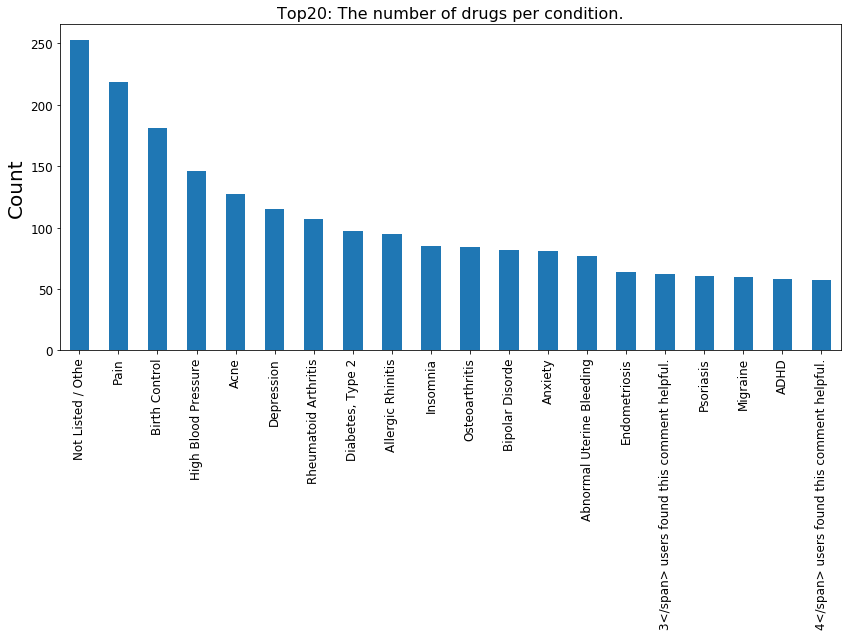

In [8]:
condition_dn = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_dn[0:20].plot(kind="bar", figsize = (14,6), fontsize = 12)
plt.xlabel("", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.title("Top20: The number of drugs per condition.", fontsize = 16)

We can observe from the graph above, the number of drugs for top eight conditions is about 100 for each condition. On the other hand, we noticed that the phrase "3</span> users found this comment helpful" appears in the condition, which seems like an error in the crawling process. We have looked into it to see in more details.

In [9]:
df_all[df_all['condition']=='3</span> users found this comment helpful.'].head(3)

,ID,drugName,condition,review,rating,date,usefulCount
242,81588,Yaz,3</span> users found this comment helpful.,"""I took Yaz for a little over 2 years. From a...",3.0,2010-06-01,3
1863,124318,Skyla,3</span> users found this comment helpful.,"""Never pregnant,28,retroverted small (6cm) ute...",1.0,2015-12-16,3
3321,202848,ProAir HFA,3</span> users found this comment helpful.,"""I get chest colds and asthmatic symptoms in t...",9.0,2015-12-12,3


It is expected that for structure of '</ span> users found this comment helpful.' phrase, there will be not only 3, but also 4 as shown above, and other numbers as well. Hence, we removed these data in the future preprocessing.

The following are the low 20 conditions of 'drugs per condition'. As we can see, the number is all 1. Considering the recommendation system, it is not feasible to recommend with that when there is only one product. Therefore, we analysed only the conditions that have at least 2 drugs per condition.

Text(0.5,1,'Bottom20 : The number of drugs per condition.')

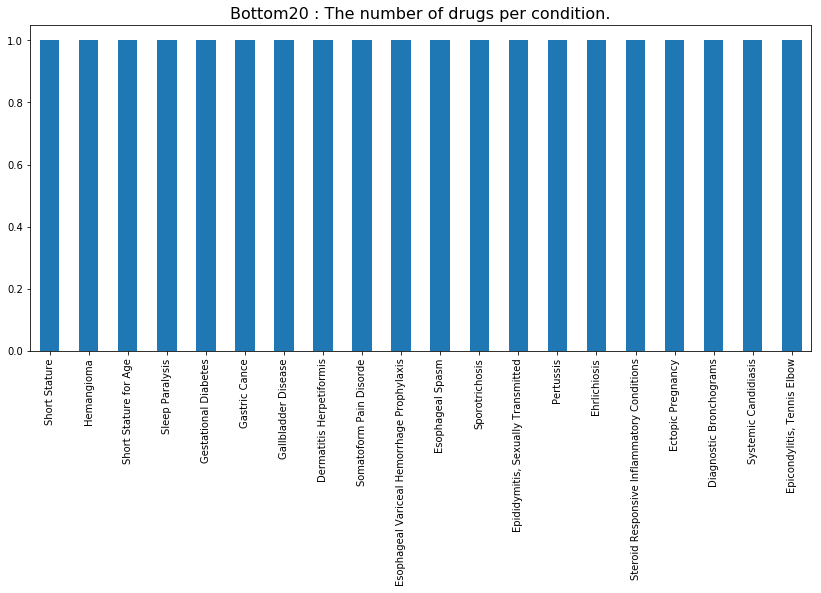

In [10]:
condition_dn = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)

condition_dn[condition_dn.shape[0]-20:condition_dn.shape[0]].plot(kind="bar", figsize = (14,6))
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Bottom20 : The number of drugs per condition.", fontsize = 16)

As we look at the first review. First, noticeable parts are the html strings like \ r \ n, and the parts that express emotions in parentheses such as (very unusual for him) and (a good thing) and words in capital letters like MUCH.

In [11]:
df_train['review'][1]

'"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."'

In addition, there were some words with errors like didn&# 039;t for didn't, and also characters like ...

In [12]:
df_train['review'][2]

'"This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch"'

We eliminated these parts in preprocessing as well.

We have classified 1 ~ 5 as negative, and 6 ~ 10 as positive, and checked through 1 ~ 4 grams which corpus best classifies emotions.

In [14]:
df_all_6_10 = df_all[df_all["rating"]>5]
df_all_1_5 = df_all[df_all["rating"]<6]

In [15]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

def horizontal_bar_chart(df, color):
    trace = go.Bar(y=df["word"].values[::-1], x=df["wordcount"].values[::-1],
                   showlegend=False, orientation = 'h', marker=dict(color=color,))
    return trace

freq_dict = defaultdict(int)

for sent in df_all_1_5["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1

fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

freq_dict = defaultdict(int)
for sent in df_all_6_10["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1

fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of rating 1 to 5", 
                                          "Frequent words of rating 6 to 10"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

F:\Anaconda\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



When we used 1-gram, we observed that the top 5 words have the same contents, although the order of left (negative) and right (positive) are different. This means when we analyzed the text with a single corpus, it does not classify the emotion well. So, we expanded the corpus.

In [16]:
freq_dict = defaultdict(int)
for sent in df_all_1_5["review"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

freq_dict = defaultdict(int)
for sent in df_all_6_10["review"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent biagrams of rating 1 to 5", 
                                          "Frequent biagrams of rating 6 to 10"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1000, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

F:\Anaconda\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



Likewise, in 2-gram, the contents of the top five corpus are similar, and it will be hard to classify positive and negative. In addition, 'side effects' and 'side effects.' are interpreted differently, which means preprocessing of review data was necessary. However, we saw that it is better to classify emotions rather than previous 1-grams, like side effects, weight gain, and highly recommend.

In [17]:
freq_dict = defaultdict(int)
for sent in df_all_1_5["review"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

freq_dict = defaultdict(int)
for sent in df_all_6_10["review"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(50), 'green')

fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent trigrams of rating 1 to 5", 
                                          "Frequent trigrams of rating 6 to 10"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1600, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

F:\Anaconda\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



From 3-gram we saw that there is a difference between positive and negative corpus. Bad side effects, birth control pills, negative side effects are corpus that classify positive and negative.

In [18]:
freq_dict = defaultdict(int)
for sent in df_all_1_5["review"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'red')

freq_dict = defaultdict(int)
for sent in df_all_6_10["review"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(50), 'red')

fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent 4-grams of rating 1 to 5", 
                                          "Frequent 4-grams of rating 6 to 10"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1600, paper_bgcolor='rgb(233,233,233)', title="4-grams Count Plots")
py.iplot(fig, filename='word-plots')

F:\Anaconda\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



Clearly, 4-gram classifies emotions much betther than other grams. Therefore, we used 4-gram to build deep learning model.

Next, we searched for relationship between rating and weather. First of all, we counted the number of ratings.

Text(0.5,1,'Count of rating values')

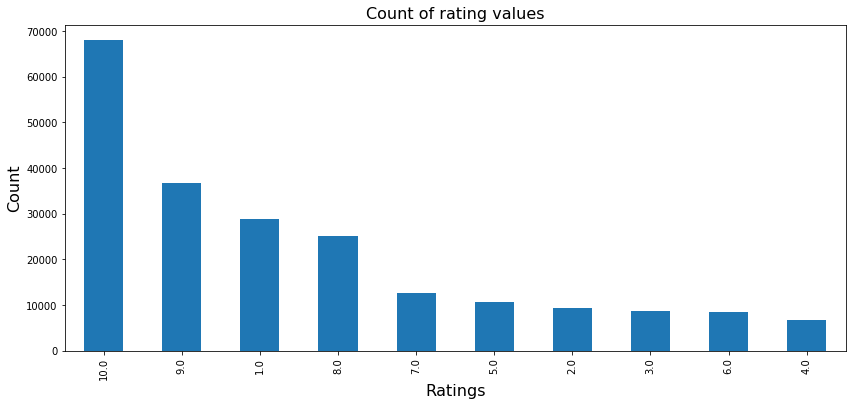

In [19]:
rating = df_all['rating'].value_counts().sort_values(ascending=False)
rating.plot(kind="bar", figsize = (14,6), fontsize = 10)
plt.xlabel("Ratings", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of rating values", fontsize = 16)

Most people choose four values; 10, 9, 1, 8, and the number of 10 is more than twice as many as the others. With this, we observed that the percentage of positives is higher than negative, and people's reactions are extreme.

Next, we checked the number of reviews and percentage of ratings according to weather.

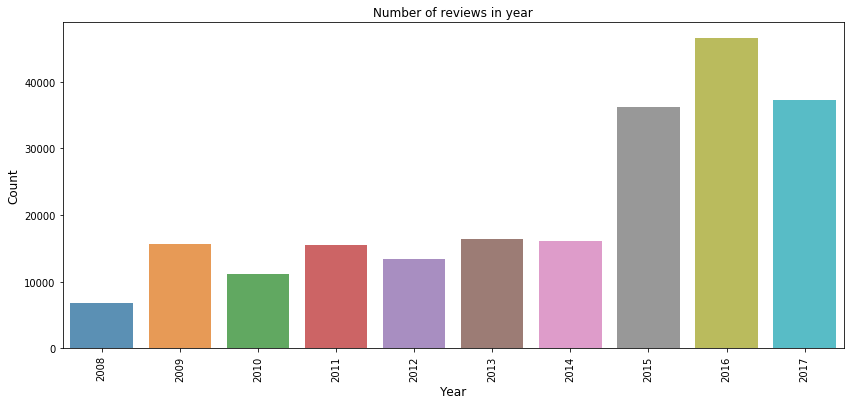

In [20]:
cnt_srs = df_all['date'].dt.year.value_counts()
cnt_srs = cnt_srs.sort_index()

plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xticks(rotation='vertical')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title("Number of reviews in year")
plt.show()

Text(0.5,1,'Mean rating in year')

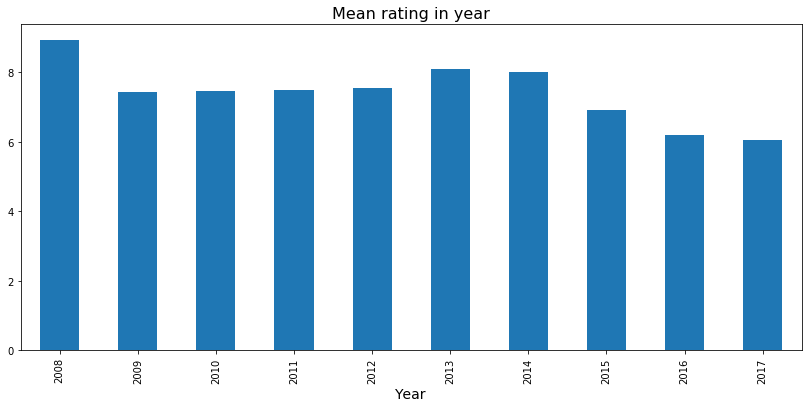

In [21]:
df_all['year'] = df_all['date'].dt.year
rating = df_all.groupby('year')['rating'].mean()
rating.plot(kind="bar", figsize = (14,6), fontsize = 10)
plt.xlabel("Year", fontsize = 14)
plt.title("Mean rating in year", fontsize = 16)

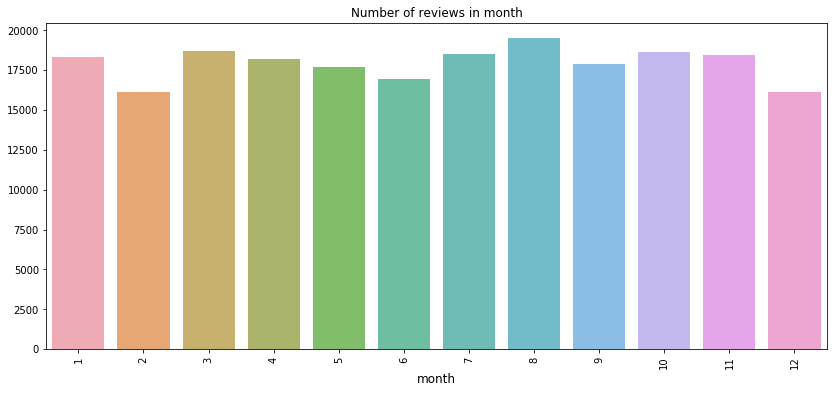

In [22]:
cnt_srs = df_all['date'].dt.month.value_counts()
cnt_srs = cnt_srs.sort_index()

plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xticks(rotation='vertical')
plt.xlabel('month', fontsize=12)
plt.title("Number of reviews in month")
plt.show()

Text(0.5,1,'Mean rating in month')

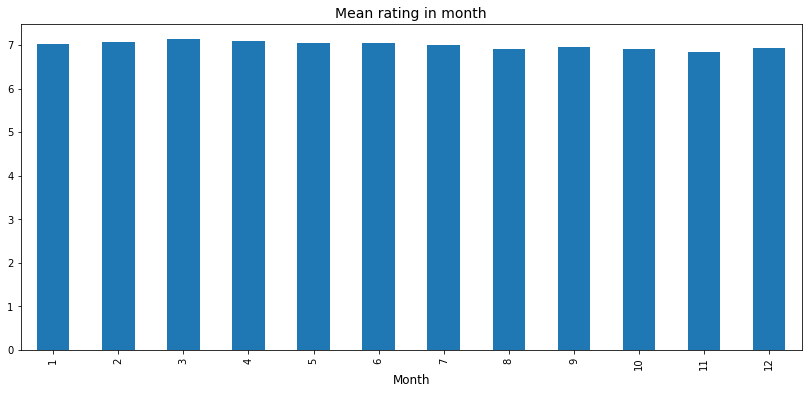

In [23]:
df_all['month'] = df_all['date'].dt.month
rating = df_all.groupby('month')['rating'].mean()
rating.plot(kind="bar", figsize = (14,6), fontsize = 10)
plt.xlabel("Month", fontsize = 12)
plt.title("Mean rating in month", fontsize = 14)

Interestingly, we see that the average rating differs by year, but it is similar by month.

Text(0.5,1,'Mean rating in day')

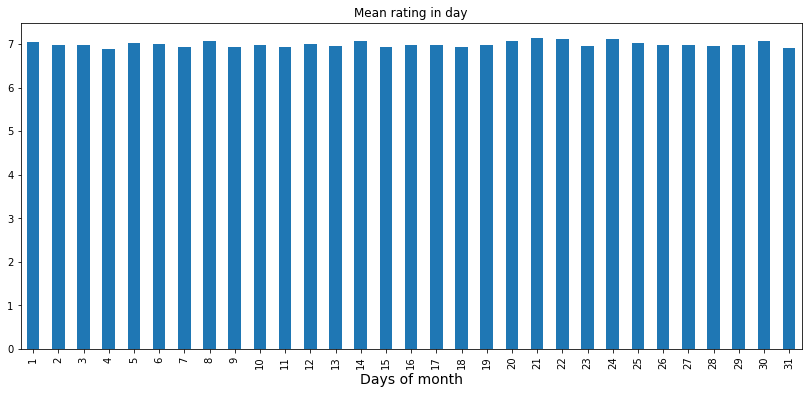

In [24]:
df_all['day'] = df_all['date'].dt.day
rating = df_all.groupby('day')['rating'].mean()
rating.plot(kind="bar", figsize = (14,6), fontsize = 10)
plt.xlabel("Days of month", fontsize = 14)
plt.title("Mean rating in day", fontsize = 12)

We checked whether the day of the week affects the rating like salary day, but it does not make a big difference.

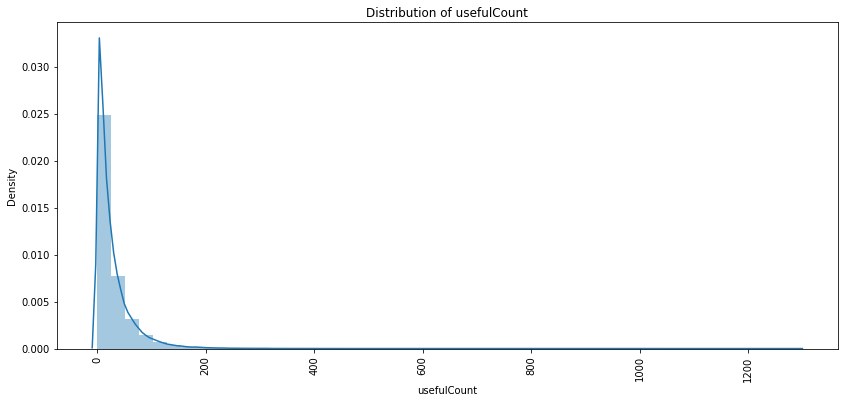

In [25]:
plt.figure(figsize=(14,6))
sns.distplot(df_all["usefulCount"].dropna())
plt.xticks(rotation='vertical')
plt.title("Distribution of usefulCount")
plt.show()

In [26]:
df_all["usefulCount"].describe()

count    215061.000000
mean         28.001037
std          36.346236
min           0.000000
25%           6.000000
50%          16.000000
75%          36.000000
max        1291.000000
Name: usefulCount, dtype: float64

We observed in the distribution of usefulCount, that the difference between minimum and maximum is 1291, which is high. In addition, the deviation is huge, which is 36. The reason for this is that the more drugs people look for, the more people read the review no matter their contents are good or bad, which makes the usefulcount very high. So when we created the model, we normalized it by conditions, considering people's accessibility.

### 1.3 Missing value

Text(0.5,1,'Total Missing Value ')

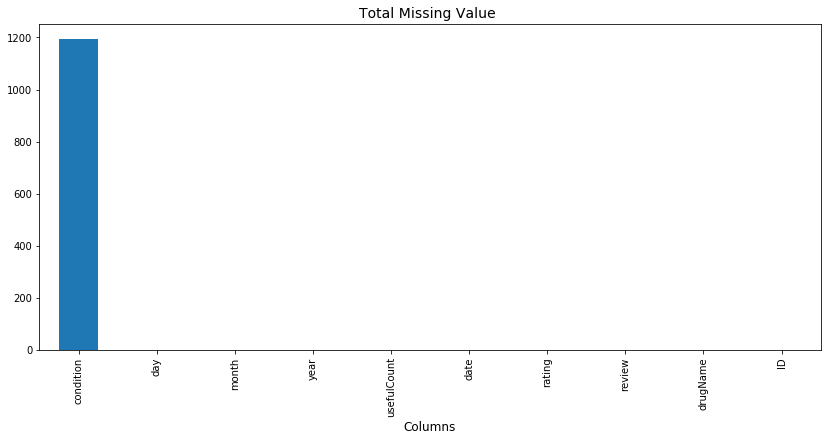

In [27]:
percent = (df_all.isnull().sum()).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (14,6))
plt.xlabel("Columns", fontsize = 12)
plt.title("Total Missing Value ", fontsize = 14)

In [28]:
print("Missing value (%):", 1200/df_all.shape[0] *100)

Missing value (%): 0.5579812239318147


We deleted the records because the percentage is lower than 1%.

## 2. Date Preprocessing

### 2.1. Missing Values Removal

In [29]:
df_train = df_train.dropna(axis=0)
df_test = df_test.dropna(axis=0)

Text(0.5,1,'Total Missing Value ')

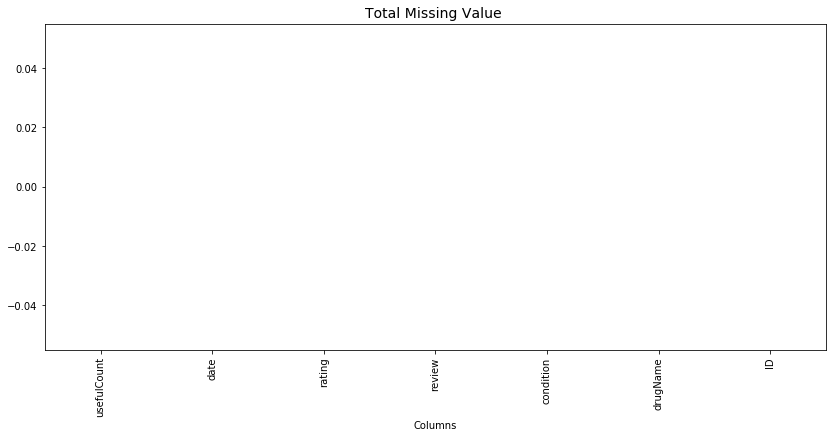

In [30]:
df_all = pd.concat([df_train,df_test]).reset_index()
del df_all['index']
percent = (df_all.isnull().sum()).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (14,6))
plt.xlabel("Columns")
plt.title("Total Missing Value ", fontsize = 14)

### 2.2 Condition Preprocessing

We will delete the sentences with the form above.

In [31]:
all_list = set(df_all.index)
span_list = []
for i,j in enumerate(df_all['condition']):
    if '</span>' in j:
        span_list.append(i)

In [32]:
new_idx = all_list.difference(set(span_list))
df_all = df_all.iloc[list(new_idx)].reset_index()
del df_all['index']

We deleted conditions with only one drug.

In [33]:
df_condition = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
df_condition = pd.DataFrame(df_condition).reset_index()
df_condition.tail(20)

,condition,drugName
816,Hemangioma,1
817,Q Feve,1
818,Urinary Retention,1
819,Diagnostic Bronchograms,1
820,Steroid Responsive Inflammatory Conditions,1
821,Cluster-Tic Syndrome,1
822,Nausea (phosphorated carbohydrate solution),1
823,Ramsay Hunt Syndrome,1
824,Rat-bite Feve,1
825,Hemorrhoids (pramoxine / zinc oxide),1


In [34]:
df_condition_1 = df_condition[df_condition['drugName']==1].reset_index()
df_condition_1['condition'][0:10]

0                           Uveitis, Posteri
1                    Pseudogout, Prophylaxis
2                        Infectious Diarrhea
3                   Thyroid Suppression Test
4                                 Angioedema
5                                Scleroderma
6                                        mis
7            Anti NMDA Receptor Encephalitis
8                                     mist (
9    Pruritus of Partial Biliary Obstruction
Name: condition, dtype: object

In [35]:
all_list = set(df_all.index)
condition_list = []
for i,j in enumerate(df_all['condition']):
    for c in list(df_condition_1['condition']):
        if j == c:
            condition_list.append(i)
            
new_idx = all_list.difference(set(condition_list))
df_all = df_all.iloc[list(new_idx)].reset_index()
del df_all['index']

### 2.3 Review Preprocessing

- \r\n : We converted the text into html grammer
- ... , &#039; : deal with not alphabet

In [37]:
stops = set(stopwords.words('english'))

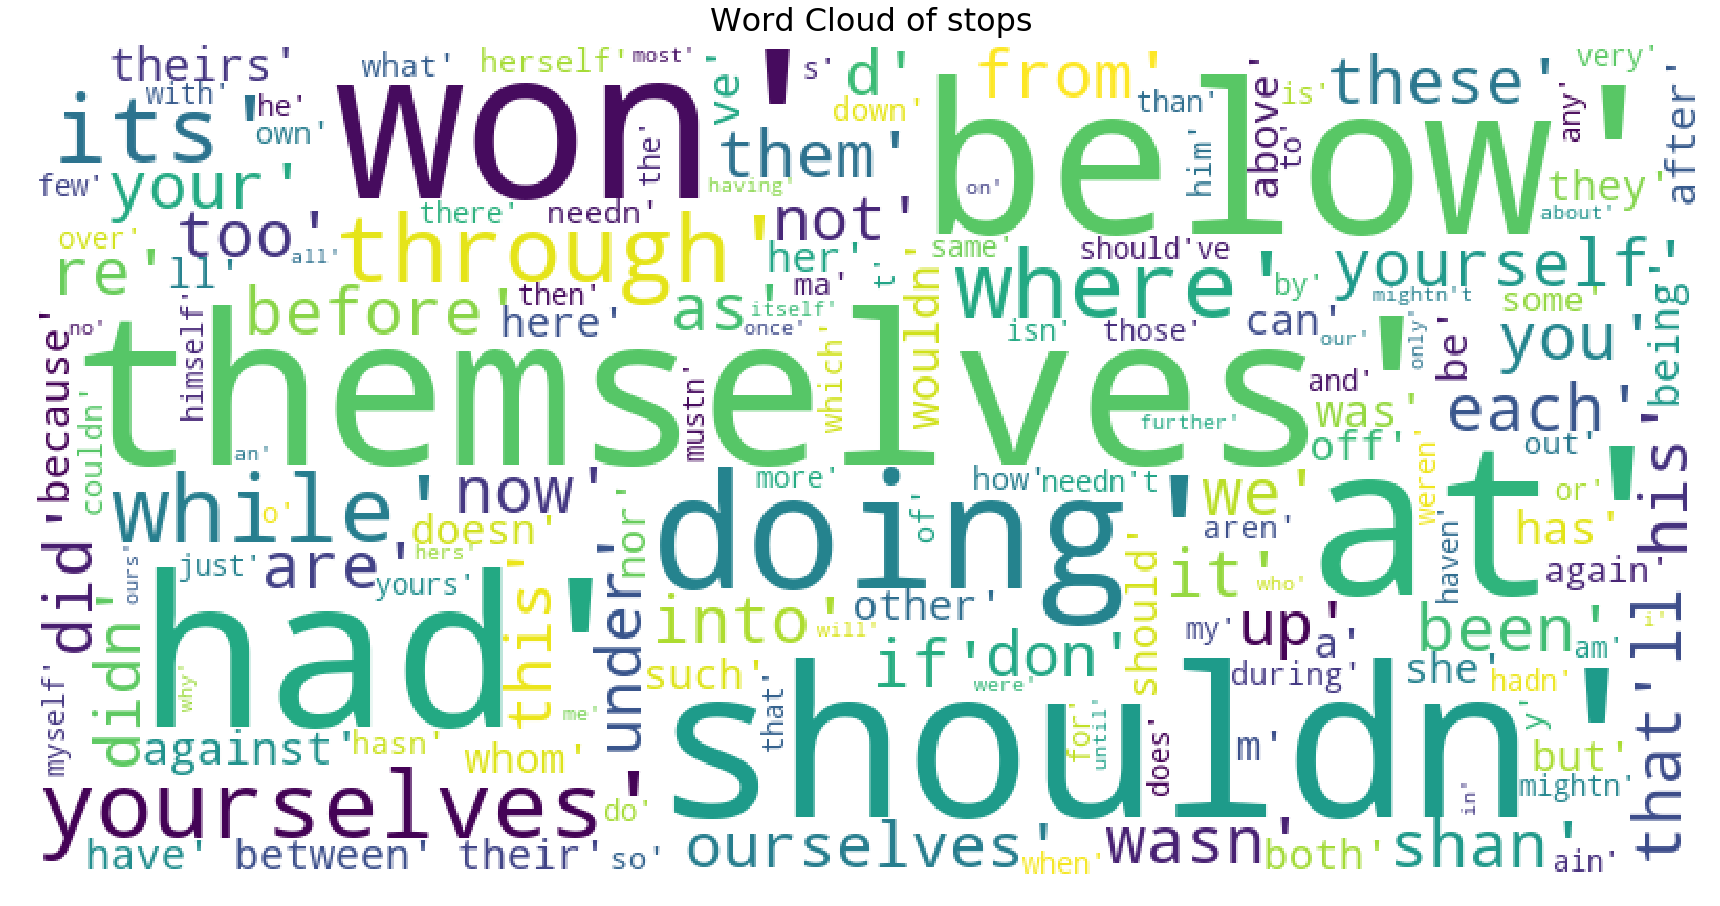

In [38]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=(24,16))
    
    plt.imshow(wordcloud);
    plt.title("Word Cloud of stops", fontdict={'size': 32, 'color': 'black', 'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(stops)

We saw what words are used as stopwords. There are many words that include not, like needn't. These words are key parts of emotional analysis, so we removed them from stopwords.

In [39]:
not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [42]:
stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    words = letters_only.lower().split()
    meaningful_words = [w for w in words if not w in stops]
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    return( ' '.join(stemming_words))

In [43]:
%time df_all['review_clean'] = df_all['review'].apply(review_to_words)

Wall time: 4min 35s


## 3. Model

### 3.1. Deep Learning Model Using N-gram

In [44]:
df_all['sentiment'] = df_all["rating"].apply(lambda x: 1 if x > 5 else 0)

In [45]:
df_train, df_test = train_test_split(df_all, test_size=0.33, random_state=42) 

In [46]:
vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2,
                             ngram_range=(4, 4),
                             max_features = 20000
                            )
vectorizer

CountVectorizer(max_features=20000, min_df=2, ngram_range=(4, 4))

In [47]:
pipeline = Pipeline([
    ('vect', vectorizer),
])

In [48]:
%time train_data_features = pipeline.fit_transform(df_train['review_clean'])
%time test_data_features = pipeline.fit_transform(df_test['review_clean'])

Wall time: 38.2 s
Wall time: 22.8 s


In [49]:
y_train = df_train['sentiment']
y_test = df_test['sentiment']
solution = y_test.copy()

# 2. Model Structure
model = keras.models.Sequential()

model.add(keras.layers.Dense(200, input_shape=(20000,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(300))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# 3. Model compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               4000200   
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               60300     
_________________________________________________________________
batch_normalization_2 (Batch (None, 300)               1200      
_________________________________________________________________
activation_2 (Activation)    (None, 300)               0         
__________

Epoch 1/10
142075/142075 [==============================] - 169s 1ms/step - loss: 0.5794 - acc: 0.7153
Epoch 2/10
142075/142075 [==============================] - 168s 1ms/step - loss: 0.4976 - acc: 0.7595
Epoch 3/10
142075/142075 [==============================] - 167s 1ms/step - loss: 0.4606 - acc: 0.7758
Epoch 4/10
142075/142075 [==============================] - 167s 1ms/step - loss: 0.4410 - acc: 0.7847
Epoch 5/10
142075/142075 [==============================] - 167s 1ms/step - loss: 0.4269 - acc: 0.7908
Epoch 6/10
142075/142075 [==============================] - 167s 1ms/step - loss: 0.4179 - acc: 0.7947
Epoch 7/10
142075/142075 [==============================] - 167s 1ms/step - loss: 0.4114 - acc: 0.7972
Epoch 8/10
142075/142075 [==============================] - 167s 1ms/step - loss: 0.4058 - acc: 0.7991
Epoch 9/10
142075/142075 [==============================] - 169s 1ms/step - loss: 0.4009 - acc: 0.8017
Epoch 10/10
142075/142075 [==============================] - 169s 1ms/ste

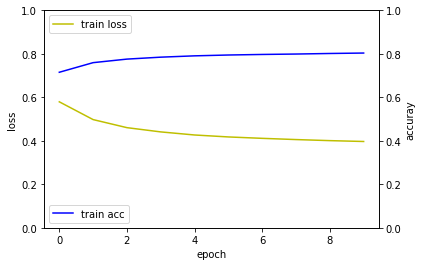

69978/69978 [==============================] - 24s 347us/step
loss_and_metrics : [1.0609793764520936, 0.6445311383543625]


In [51]:
hist = model.fit(train_data_features, y_train, epochs=10, batch_size=64)

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['acc'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

loss_and_metrics = model.evaluate(test_data_features, y_test, batch_size=32)
print('loss_and_metrics : ' + str(loss_and_metrics))

In [52]:
sub_preds_deep = model.predict(test_data_features,batch_size=32)

### 3.2 Lightgbm

To improve the low accuracy, we will use machine learning. First of all, this is the sentiment analysis model using only usefulCount.

In [53]:
target = df_train['sentiment']
feats = ['usefulCount']

sub_preds = np.zeros(df_test.shape[0])

trn_x, val_x, trn_y, val_y = train_test_split(df_train[feats], target, test_size=0.2, random_state=42) 
feature_importance_df = pd.DataFrame() 
    
clf = LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.05,
        num_leaves=30,
        #colsample_bytree=.9,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
        
clf.fit(trn_x, trn_y, 
        eval_set= [(trn_x, trn_y), (val_x, val_y)], 
        verbose=100, early_stopping_rounds=100  #30
    )

sub_preds = clf.predict(df_test[feats])
        
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = clf.feature_importances_
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.570406	valid_1's binary_logloss: 0.572234
[200]	training's binary_logloss: 0.570206	valid_1's binary_logloss: 0.572221
Early stopping, best iteration is:
[168]	training's binary_logloss: 0.570241	valid_1's binary_logloss: 0.572209


In [54]:
solution = df_test['sentiment']
confusion_matrix(y_pred=sub_preds, y_true=solution)

array([[    0, 21009],
       [    0, 48969]])

We will add variables for higher accuracy.

In [55]:
len_train = df_train.shape[0]
df_all = pd.concat([df_train,df_test])
del df_train, df_test;
gc.collect()

3437

In [56]:
df_all['date'] = pd.to_datetime(df_all['date'])
df_all['day'] = df_all['date'].dt.day
df_all['year'] = df_all['date'].dt.year
df_all['month'] = df_all['date'].dt.month

In [57]:
reviews = df_all['review_clean']

Predict_Sentiment = []
for review in tqdm(reviews):
    blob = TextBlob(review)
    Predict_Sentiment += [blob.sentiment.polarity]
df_all["Predict_Sentiment"] = Predict_Sentiment
df_all.head()

100%|██████████| 212053/212053 [03:04<00:00, 1146.58it/s]


,uniqueID,drugName,condition,review,rating,date,usefulCount,review_clean,sentiment,day,year,month,Predict_Sentiment
130185,66913,Seroquel,Generalized Anxiety Disorde,"""After trying nearly every SSRI on the market ...",9,2010-11-26,102,tri near everi ssri market place pristiq impro...,1,26,2010,11,0.023958
155501,222222,Fluconazole,"Onychomycosis, Toenail","""This takes 6+ months, but did clear up a deca...",9,2008-05-03,39,take month clear decad long infect,1,3,2008,5,0.025000
75325,75807,Temazepam,Insomnia,"""Worked for awhile pretty well but then went b...",2,2016-04-21,15,work awhil pretti well went back mayb get hour...,0,21,2016,4,-0.125000
19174,229747,Ketamine,Pain,"""I was given this after surgery for pain as I ...",1,2016-04-16,19,given surgeri pain morphin tri drug sort omg w...,0,16,2016,4,0.166667
209735,102495,Aripiprazole,Major Depressive Disorde,"""Abilify served me well over a two month perio...",9,2016-12-16,5,abilifi serv well two month period antidepress...,1,16,2016,12,0.038889


In [58]:
np.corrcoef(df_all["Predict_Sentiment"], df_all["rating"])

array([[1.        , 0.25709864],
       [0.25709864, 1.        ]])

In [59]:
np.corrcoef(df_all["Predict_Sentiment"], df_all["sentiment"])

array([[1.        , 0.23518272],
       [0.23518272, 1.        ]])

In [60]:
reviews = df_all['review']

Predict_Sentiment = []
for review in tqdm(reviews):
    blob = TextBlob(review)
    Predict_Sentiment += [blob.sentiment.polarity]
df_all["Predict_Sentiment2"] = Predict_Sentiment

100%|██████████| 212053/212053 [04:57<00:00, 713.75it/s]


In [61]:
np.corrcoef(df_all["Predict_Sentiment2"], df_all["rating"])

array([[1.        , 0.34831213],
       [0.34831213, 1.        ]])

In [62]:
np.corrcoef(df_all["Predict_Sentiment2"], df_all["sentiment"])

array([[1.        , 0.31714515],
       [0.31714515, 1.        ]])

In [63]:
df_all['count_sent']=df_all["review"].apply(lambda x: len(re.findall("\n",str(x)))+1)

#Word count in each comment
df_all['count_word']=df_all["review_clean"].apply(lambda x: len(str(x).split()))

#Unique word count
df_all['count_unique_word']=df_all["review_clean"].apply(lambda x: len(set(str(x).split())))

#Letter count
df_all['count_letters']=df_all["review_clean"].apply(lambda x: len(str(x)))

#punctuation count
df_all["count_punctuations"] = df_all["review"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count
df_all["count_words_upper"] = df_all["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#title case words count
df_all["count_words_title"] = df_all["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Number of stopwords
df_all["count_stopwords"] = df_all["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in stops]))

#Average length of the words
df_all["mean_word_len"] = df_all["review_clean"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

We added a season variable.

In [64]:
df_all['season'] = df_all["month"].apply(lambda x: 1 if ((x>2) & (x<6)) else(2 if (x>5) & (x<9) else (3 if (x>8) & (x<12) else 4)))

We normalized useful count.

In [65]:
df_train = df_all[:len_train]
df_test = df_all[len_train:]

In [66]:
target = df_train['sentiment']
feats = ['usefulCount','day','year','month','Predict_Sentiment','Predict_Sentiment2', 'count_sent',
 'count_word', 'count_unique_word', 'count_letters', 'count_punctuations',
 'count_words_upper', 'count_words_title', 'count_stopwords', 'mean_word_len', 'season']

sub_preds = np.zeros(df_test.shape[0])

trn_x, val_x, trn_y, val_y = train_test_split(df_train[feats], target, test_size=0.2, random_state=42) 
feature_importance_df = pd.DataFrame() 
    
clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.10,
        num_leaves=30,
        #colsample_bytree=.9,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
        
clf.fit(trn_x, trn_y, 
        eval_set= [(trn_x, trn_y), (val_x, val_y)], 
        verbose=100, early_stopping_rounds=100  #30
    )

sub_preds = clf.predict(df_test[feats])
        
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = clf.feature_importances_
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.481279	valid_1's binary_logloss: 0.494978
[200]	training's binary_logloss: 0.464017	valid_1's binary_logloss: 0.489836
[300]	training's binary_logloss: 0.448687	valid_1's binary_logloss: 0.485795
[400]	training's binary_logloss: 0.434477	valid_1's binary_logloss: 0.481708
[500]	training's binary_logloss: 0.422172	valid_1's binary_logloss: 0.478113
[600]	training's binary_logloss: 0.410153	valid_1's binary_logloss: 0.4747
[700]	training's binary_logloss: 0.399379	valid_1's binary_logloss: 0.471887
[800]	training's binary_logloss: 0.388203	valid_1's binary_logloss: 0.468779
[900]	training's binary_logloss: 0.377657	valid_1's binary_logloss: 0.465732
[1000]	training's binary_logloss: 0.367101	valid_1's binary_logloss: 0.462981
[1100]	training's binary_logloss: 0.357608	valid_1's binary_logloss: 0.460332
[1200]	training's binary_logloss: 0.348188	valid_1's binary_logloss: 0.457833
[1300]	train

In [67]:
confusion_matrix(y_pred=sub_preds, y_true=solution)

array([[13698,  7311],
       [ 3664, 45305]])

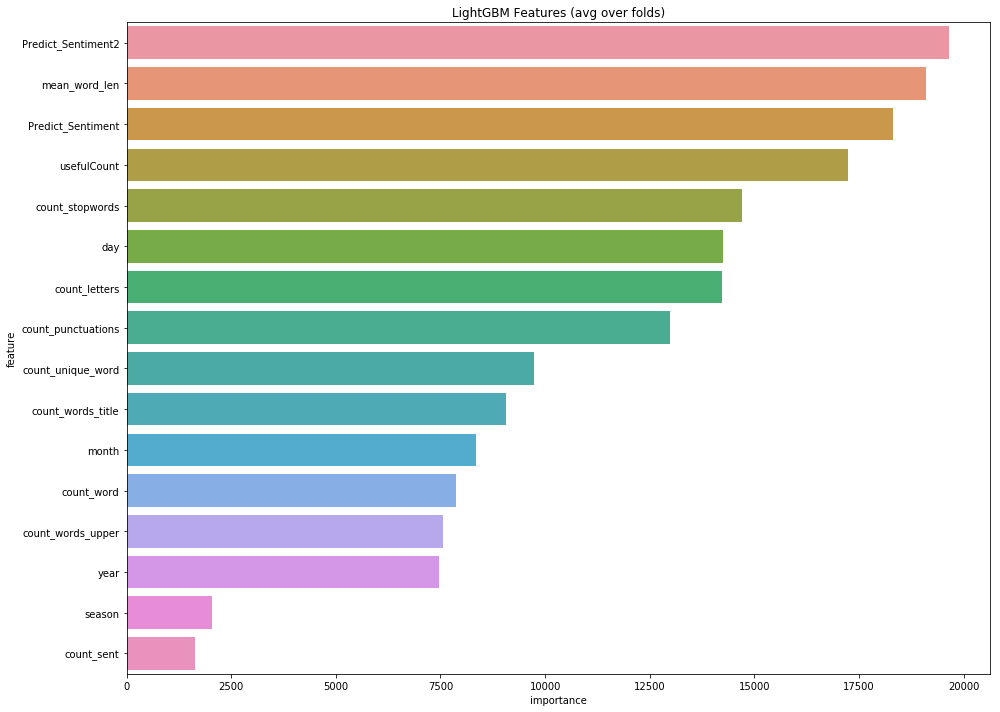

In [68]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

### 3.3 Dictionary_Sentiment_Analysis

Because the package used for prediction of 'Predict value' is formed with movie review data, it can be unsuitable for this project which analyzes reviews for drugs. To make up for this, we conducted additional emotional analysis using the Harvard emotional dictionary.

In [69]:
word_table = pd.read_csv("Datasets/inquirerbasic.csv")

In [70]:
word_table.head()

,Entry,Source,Positiv,Negativ
0,A,H4Lvd,NaN,NaN
1,ABANDON,H4Lvd,NaN,Negativ
2,ABANDONMENT,H4,NaN,Negativ
3,ABATE,H4Lvd,NaN,Negativ
4,ABATEMENT,Lvd,NaN,NaN


In [71]:
temp_Positiv = []
Positiv_word_list = []
for i in range(0,len(word_table.Positiv)):
    if word_table.iloc[i,2] == "Positiv":
        temp = word_table.iloc[i,0].lower()
        temp1 = re.sub('\d+', '', temp)
        temp2 = re.sub('#', '', temp1) 
        temp_Positiv.append(temp2)

Positiv_word_list = list(set(temp_Positiv))
len(temp_Positiv)
len(Positiv_word_list)

temp_Negativ = []
Negativ_word_list = []
for i in range(0,len(word_table.Negativ)):
    if word_table.iloc[i,3] == "Negativ":
        temp = word_table.iloc[i,0].lower()
        temp1 = re.sub('\d+', '', temp)
        temp2 = re.sub('#', '', temp1) 
        temp_Negativ.append(temp2)

Negativ_word_list = list(set(temp_Negativ))
len(temp_Negativ)
len(Negativ_word_list)

2006

We counted the number of words in review_clean which are included in dictionary.

In [72]:
vectorizer = CountVectorizer(vocabulary = Positiv_word_list)
content = df_test['review_clean']
X = vectorizer.fit_transform(content)
f = X.toarray()
f = pd.DataFrame(f)
f.columns=Positiv_word_list
df_test["num_Positiv_word"] = f.sum(axis=1)

vectorizer2 = CountVectorizer(vocabulary = Negativ_word_list)
content = df_test['review_clean']
X2 = vectorizer2.fit_transform(content)
f2 = X2.toarray()
f2 = pd.DataFrame(f2)
f2.columns=Negativ_word_list
df_test["num_Negativ_word"] = f2.sum(axis=1)

In [73]:
df_test["Positiv_ratio"] = df_test["num_Positiv_word"]/(df_test["num_Positiv_word"]+df_test["num_Negativ_word"])
df_test["sentiment_by_dic"] = df_test["Positiv_ratio"].apply(lambda x: 1 if (x>=0.5) else (0 if (x<0.5) else 0.5))

df_test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,review_clean,sentiment,day,year,month,Predict_Sentiment,Predict_Sentiment2,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,season,num_Positiv_word,num_Negativ_word,Positiv_ratio,sentiment_by_dic
147354,126702,Brimonidine,Rosacea,"""Never , never , never use this cream !!!!!! I...",1,2015-08-31,17,never never never use cream help way angri dis...,0,31,2015,8,0.116667,-0.157955,1,58,41,335,58,5,11,54,4.793103,2,NaN,NaN,NaN,0.5
195249,84765,Ethinyl estradiol / norgestimate,Birth Control,"""I was switched to this after about 9 months o...",10,2016-05-01,3,switch month mononessa ask switch happen anywa...,1,1,2016,5,-0.257407,-0.210916,1,50,42,314,27,6,14,50,5.300000,1,NaN,NaN,NaN,0.5
86265,71559,Vraylar,Bipolar Disorde,"""I began at 1.5 then titrated to 3mg dosage. A...",3,2016-08-17,17,began titrat mg dosag first love medicin compl...,0,17,2016,8,0.041667,0.139815,1,41,38,251,20,6,9,41,5.146341,2,NaN,NaN,NaN,0.5
44172,132320,Ativan,Anxiety,"""Ativan 0.5mg calms me down considerably withi...",5,2012-01-12,26,ativan mg calm consider within minut side effe...,0,12,2012,1,-0.170530,-0.061481,1,62,54,353,27,7,8,55,4.709677,4,0.0,4.0,0.0,0.0
90569,177278,Duloxetine,Generalized Anxiety Disorde,"""My thoughts on Cymbalta: Cymbalta has left me...",1,2017-05-03,29,thought cymbalta cymbalta left fog no feel non...,0,3,2017,5,0.071429,-0.122253,2,68,61,395,38,12,19,65,4.823529,1,NaN,NaN,NaN,0.5


We defined Positiv_ratio = the number of positive words / (the number of positive words + the number of negative words) If the ratio is lower than 0.5, we classified as negative and if it's higher than 0.5, we classified as positive. With remainders, we classified as neutral, which includes the sentence without either positive or negative words.

As mentioned earlier, we have normalized usefulCount by condition to solve the problem that usefulCount shows bias depending on condition. We then added three predicted emotion values and multiply them by the normalized usefulCount to get the predicted value.

With this we were able to recommend drug by condition in order of final predicted value.

In [74]:
def userful_count(data):
    grouped = data.groupby(['condition']).size().reset_index(name='user_size')
    data = pd.merge(data,grouped,on='condition',how='left')
    return data

df_test =  userful_count(df_test) 
df_test['usefulCount'] = df_test['usefulCount']/df_test['user_size']

In [75]:
df_test['deep_pred'] = sub_preds_deep
df_test['machine_pred'] = sub_preds

df_test['total_pred'] = (df_test['deep_pred'] + df_test['machine_pred'] + df_test['sentiment_by_dic'])*df_test['usefulCount']

In [76]:
df_test = df_test.groupby(['condition','drugName']).agg({'total_pred' : ['mean']})
df_test

total_pred
                                                               mean
condition                drugName                                  
ADHD                     Adderall                          0.070023
                         Adderall XR                       0.042444
                         Adzenys XR-ODT                    0.010508
                         Amantadine                        0.011038
                         Amphetamine                       0.013946
                         Amphetamine / dextroamphetamine   0.046797
                         Aptensio XR                       0.005855
                         Armodafinil                       0.027926
                         Atomoxetine                       0.047760
                         Bupropion                         0.084859
                         Catapres                          0.044392
                         Clonidine                         0.058757
                         Concerta                          0.058632
                         Cylert                            0.014638
                         Daytrana                          0.031663
                         Desoxyn                           0.130644
                         Desvenlafaxine                    0.006061
                         Dexedrine                         0.064782
                         Dexmethylphenidate                0.041749
                         Dextroamphetamine                 0.052349
                         Dextrostat                        0.045377
                         Dyanavel XR                       0.016378
                         Evekeo                            0.008560
                         Focalin                           0.046721
                         Focalin XR                        0.044702
                         Guanfacine                        0.069605
                         Intuniv                           0.078113
                         Kapvay                            0.127608
                         Lisdexamfetamine                  0.045251
                         Metadate CD                       0.037593
...                                                             ...
ibromyalgia              Nuvigil                           0.257571
                         Prednisone                        0.082614
                         Pregabalin                        0.130479
                         Pristiq                           0.079282
                         Prozac                            0.185853
                         Savella                           0.113673
                         Skelaxin                          0.084142
                         Sodium oxybate                    0.103717
                         Sterapred DS                      0.056891
                         Topamax                           0.043799
                         Topiramate                        0.060077
                         Tramadol                          0.109870
                         Trazodone                         0.054645
                         Ultram                            0.079947
                         Ultram ER                         0.086489
                         Venlafaxine                       0.068417
                         Xyrem                             0.246492
lic Acid Deficiency      Deplin                            9.561251
                         L-methylfolate                    6.035506
m Pain Disorde           Milnacipran                       0.000000
min)                     Alogliptin / metformin            0.229274
                         Dapagliflozin / metformin         0.210445
                         Empagliflozin / metformin         1.130246
                         Linagliptin / metformin           0.932860
                         Metformin                         9.299290
moterol)                 Arformoterol        

## 4. Conclusion

The team performed the analysis and recommended the medicine/drug name for the patient's condition. The reviews were analyzed, and as we moved further in the project, we worked with data preprocessing and modelling. In conclusion, there were some points which we observed:
1. When we implemented the sentiment word dictionary, it had low reliability when the positive and negative words were small. For example, if there were 0 positive words in the sentence and one negative word, the sentence was negative. Hence, if the number of sentiment words was five or less, we removed the observations.
2. As we have considered the normalized usefulCount to determine the predicted values. The parameter may tend to be higher for the older reviews as the number of visitors increased. Hence, we can consider the time parameter as well.
